# GVHD Use Case : Q&A Example

### Use Case Background

The data in this tutorial comes from a RAG-based bot that answers questions about the GVHD medical condition.

This tutorial is a subset of the [full demo](https://llmdocs.deepchecks.com/docs/qa-demo-gvhd-use-case) which will focus on version comparison using the Deepchecks platform.

A first version was built and inspected using deepchecks. Following missing information and hallucinations that were deteceted, it was improved. The improved version was then deployed to production.

The datasets used for this example can be downloaded from [this link](https://figshare.com/articles/dataset/GVHD_Demo_Data_Basic/27835209)

### Install the Deepchecks Python SDK client, import modules, and set your API key

In [ ]:
! pip install deepchecks-llm-client[sagemaker] -U

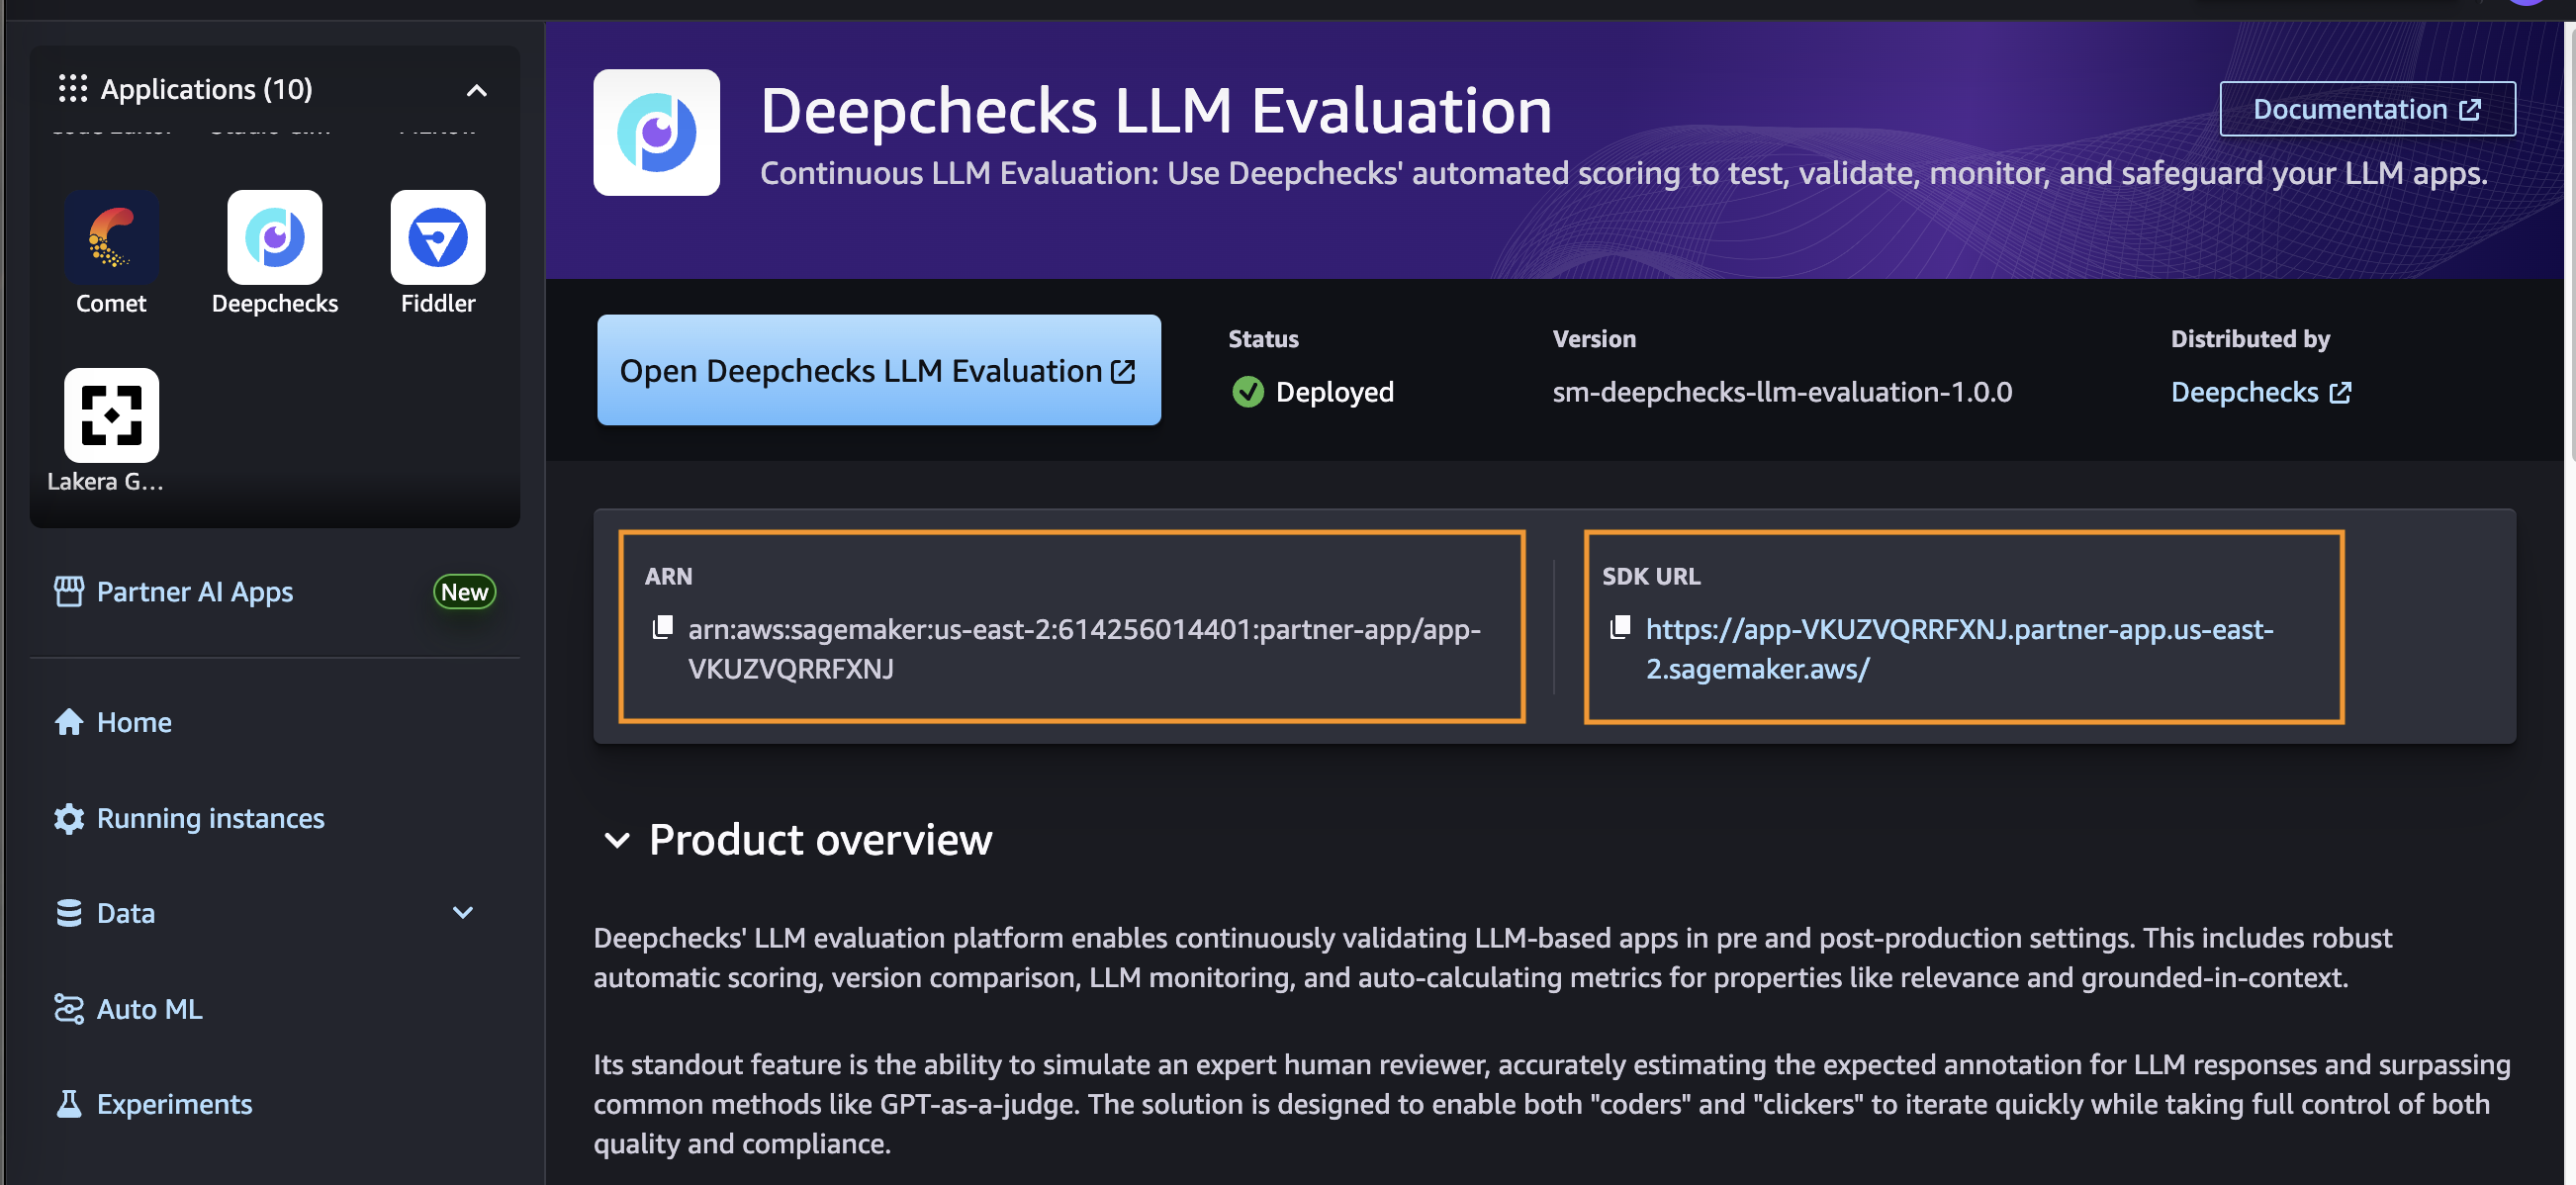

In [ ]:
import os

# Get your API KEY from the deepchecks UI, and the relevant host url and place them here

# For SageMaker Studio -> Partner AI Apps -> Deepchecks -> View Details
# For SageMaker Unified Studio -> Build -> Partner AI Apps -> Deepchecks -> View Details
# Grab the SDK URL and ARN from Details page to use below

os.environ["AWS_PARTNER_APP_AUTH"] = "True"
os.environ["AWS_PARTNER_APP_ARN"] = "" # View Details -> ARN
os.environ["AWS_PARTNER_APP_URL"] = "" # View Details -> SDK URL
os.environ["DEEPCHECKS_API_KEY"] = "" # Click Open Deepchecks from SageMaker Studio -> Partner AI Apps -> Bottom Left user icon -> API Key -> Regenerate -> Copy key
os.environ['DEEPCHECKS_HOST'] = "" # View Details -> SDK URL

### Initialize the Deepchecks SDK client and Create Your Application

In [ ]:
from deepchecks_llm_client.client import DeepchecksLLMClient
from deepchecks_llm_client.data_types import ApplicationType

# Choose an app name for the application:
APP_NAME = "QA-Demo-GVHD-Comparison"

dc_client = DeepchecksLLMClient(api_token=os.getenv('DEEPCHECKS_API_KEY'), \
                                host=os.getenv('DEEPCHECKS_HOST'))
dc_client.create_application(APP_NAME, ApplicationType.QA)

#### Update Auto-annotation configuration (improve annotation)

In [ ]:
import requests

# update auto-annotation configuration, with new config from this link:
# https://figshare.com/articles/software/Q_A_New_Config_Yaml_Example/27324198?file=50868336

url = "https://figshare.com/ndownloader/files/50868336"
response = requests.get(url)
new_yaml_filename = "qa_no-llmprops.yaml"

# Check if the request was successful
if response.status_code == 200:
    # Write the content to a file
    with open(new_yaml_filename, "wb") as file:
        file.write(response.content)
    print("New YAML file downloaded successfully")
else:
    print(f"Failed to download file, status code: {response.status_code}." +
    " Please get {} for upload".format(new_yaml_filename))

In [ ]:
with open(new_yaml_filename, 'rb') as f:
    dc_client.update_application_config(app_name=APP_NAME, file=f)

### Upload the Data

Upload an annotated baseline  version (each interaction has a "good" or "bad" annotation) to the evaluation environment.
This version will have all Deepchecks properties calculated on it.

In [ ]:
import pandas as pd
from deepchecks_llm_client.data_types import (EnvType, LogInteractionType)

# The datasest are available at:
# https://figshare.com/articles/dataset/GVHD_Demo_Data_Basic/27835209

# Here we're downloading each one of them directly into the dataframe
df_v1 = pd.read_csv("https://figshare.com/ndownloader/files/50598348")

dc_client.log_batch_interactions(
    app_name=APP_NAME,
    version_name="v1_llama3",
    env_type=EnvType.EVAL,
    interactions=[
        LogInteractionType(
            input=row['input'], # user input query
            information_retrieval=row['information_retrieval'], # list with retrieved documents' content
            output=row['output'], # LLM pipeline's final outputs
            annotation=row["user_annotation"], # optional: manual user annotation
            user_interaction_id=str(row['user_interaction_id']), # unique identifier within version - to allow identifying similar interactions across versions
            full_prompt=row['full_prompt'], # optional: full prompt with instructions for LLM (can exclude user's query given above in input)
            started_at=row['started_at'], # optional: timestamp of interaction. Relevant mainly for production
            annotation_reason=str(row['annotation_reason']) if pd.notna(row['annotation_reason']) else None, # optional: textual reasoning for annotation
            custom_props={'Question Type': row['cp_Question Type']}, # optional: custom property, with user-defined categories for question type
            # more details here: https://llmdocs.deepchecks.com/docs/data-structure-hierarchy and here: https://llmdocs.deepchecks.com/docs/supported-applications
        ) for _, row in df_v1.iterrows()
    ]
);

Note: once we have a version in the Evaluation environment, we can retrieve the data in order to run it through a new version's pipeline, using the [get_data](https://docs.deepchecks.com/llm-evaluation-private-version/stable/sdk/generated/deepchecks_llm_client.client.DeepchecksLLMClient.get_data.html#deepchecks_llm_client.client.DeepchecksLLMClient.get_data) SDK function

### Upload a new version for automatic evaluation

This is a new version that was fixed following the insights from the initial version: Answers Avoided and Hallucinations, following missing information in the knowledge base which was then updated.

In [ ]:
df_v2 = pd.read_csv("https://figshare.com/ndownloader/files/50598351")

# see above cell for explanation about data scructure. and or check out df_v2.head() to see structure of DataFrame columns
dc_client.log_batch_interactions(
    app_name=APP_NAME,
    version_name="v2_improved_IR",
    env_type=EnvType.EVAL,
    interactions=[
        LogInteractionType(
            input=row['input'],
            information_retrieval=row['information_retrieval'],
            output=row['output'],
            user_interaction_id=str(row['user_interaction_id']),
            full_prompt=row['full_prompt'],
            started_at=row['started_at'],
            custom_props={'Question Type': row['cp_Question Type']},
        ) for _, row in df_v2.iterrows()
    ]
);

## Comparing the Versions

> 🗒️ Note: <br>
> Some properties take some time to calculate, so some of the data - such as properties and estimated annotations will be updated over time. You'll see a "✅ Completed" Processing Status in the Applications page, when processing is finished.
>
> **Make sure to "Refresh" the Deepchecks App to get the updated results**

#### Have a look at the "Overview Screen"

On the top right you can choose which Application and which Version you're looking at.
The Overview Screen shows you the overall performance and average property values and distributions. For example, you can see that the overall performance for v2 was much better than for v1.

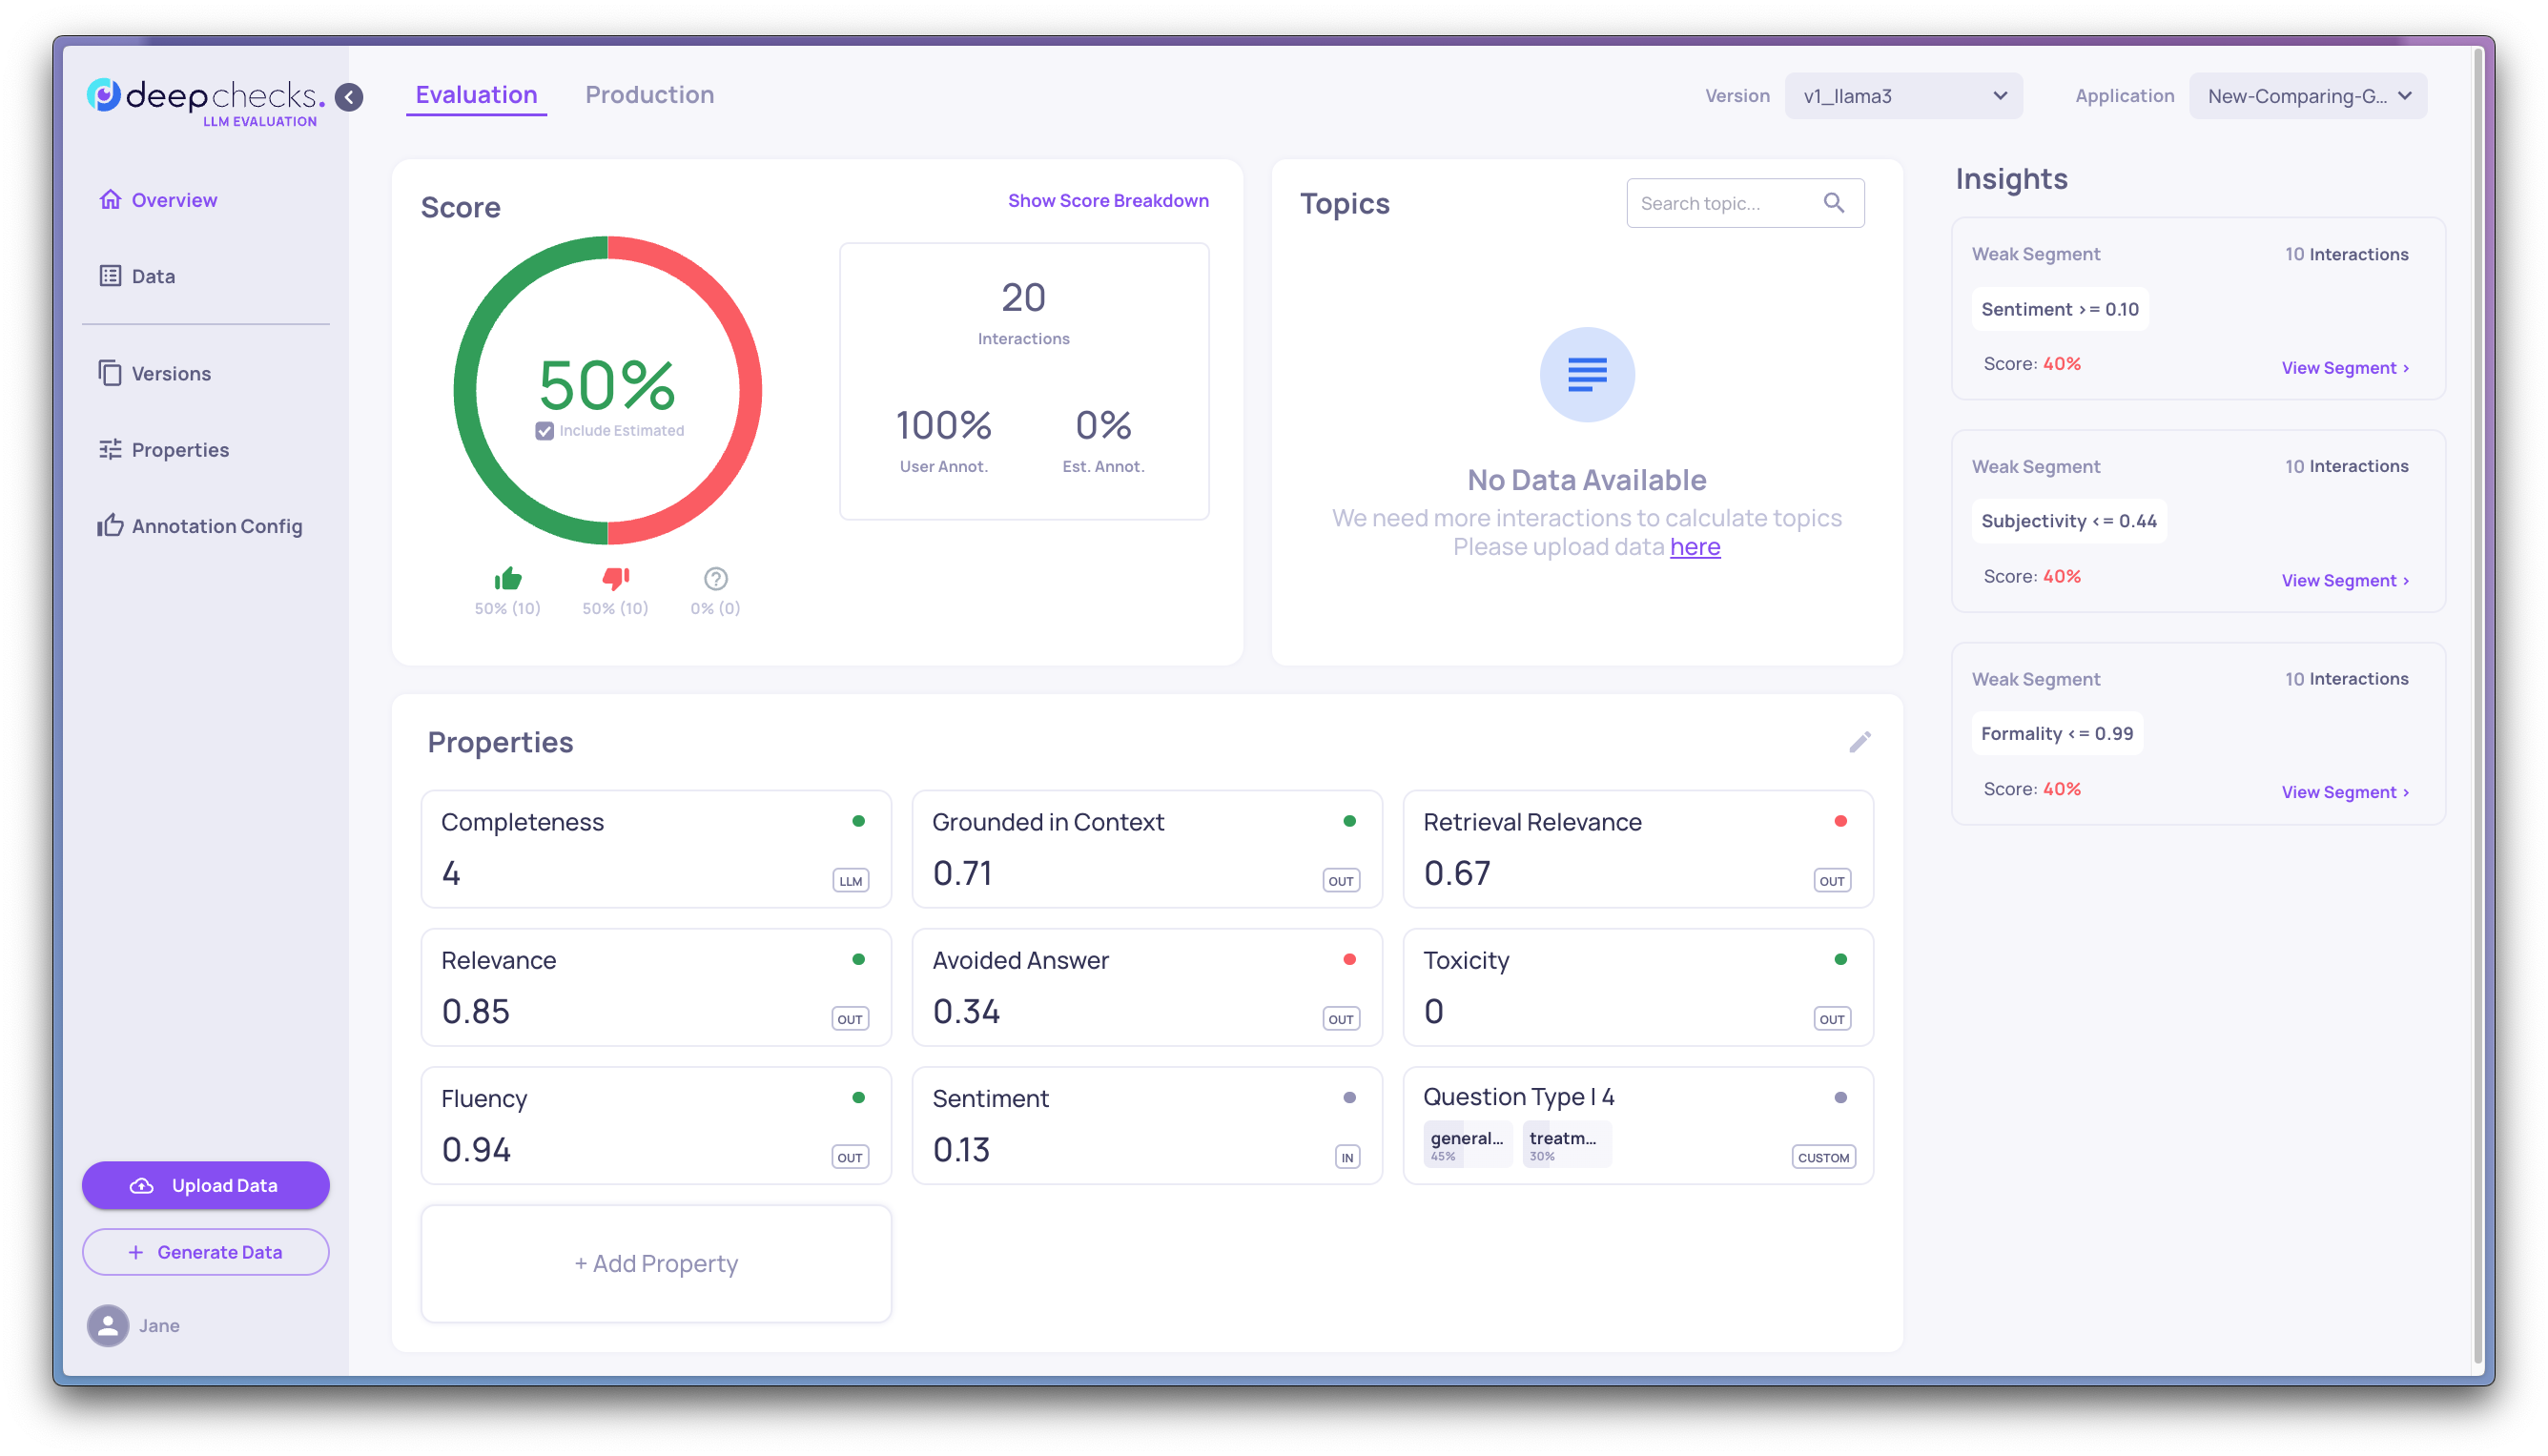

#### Data Screen

Here you can see all of the interactions. Choose which column to sort by. e.g. Sorting by "Grounded in Context" will automatically show us interactions that have low groundedness score, thus helping us find hallucinations in the data. For v1 you can see that this fits the manual human annotation reason.

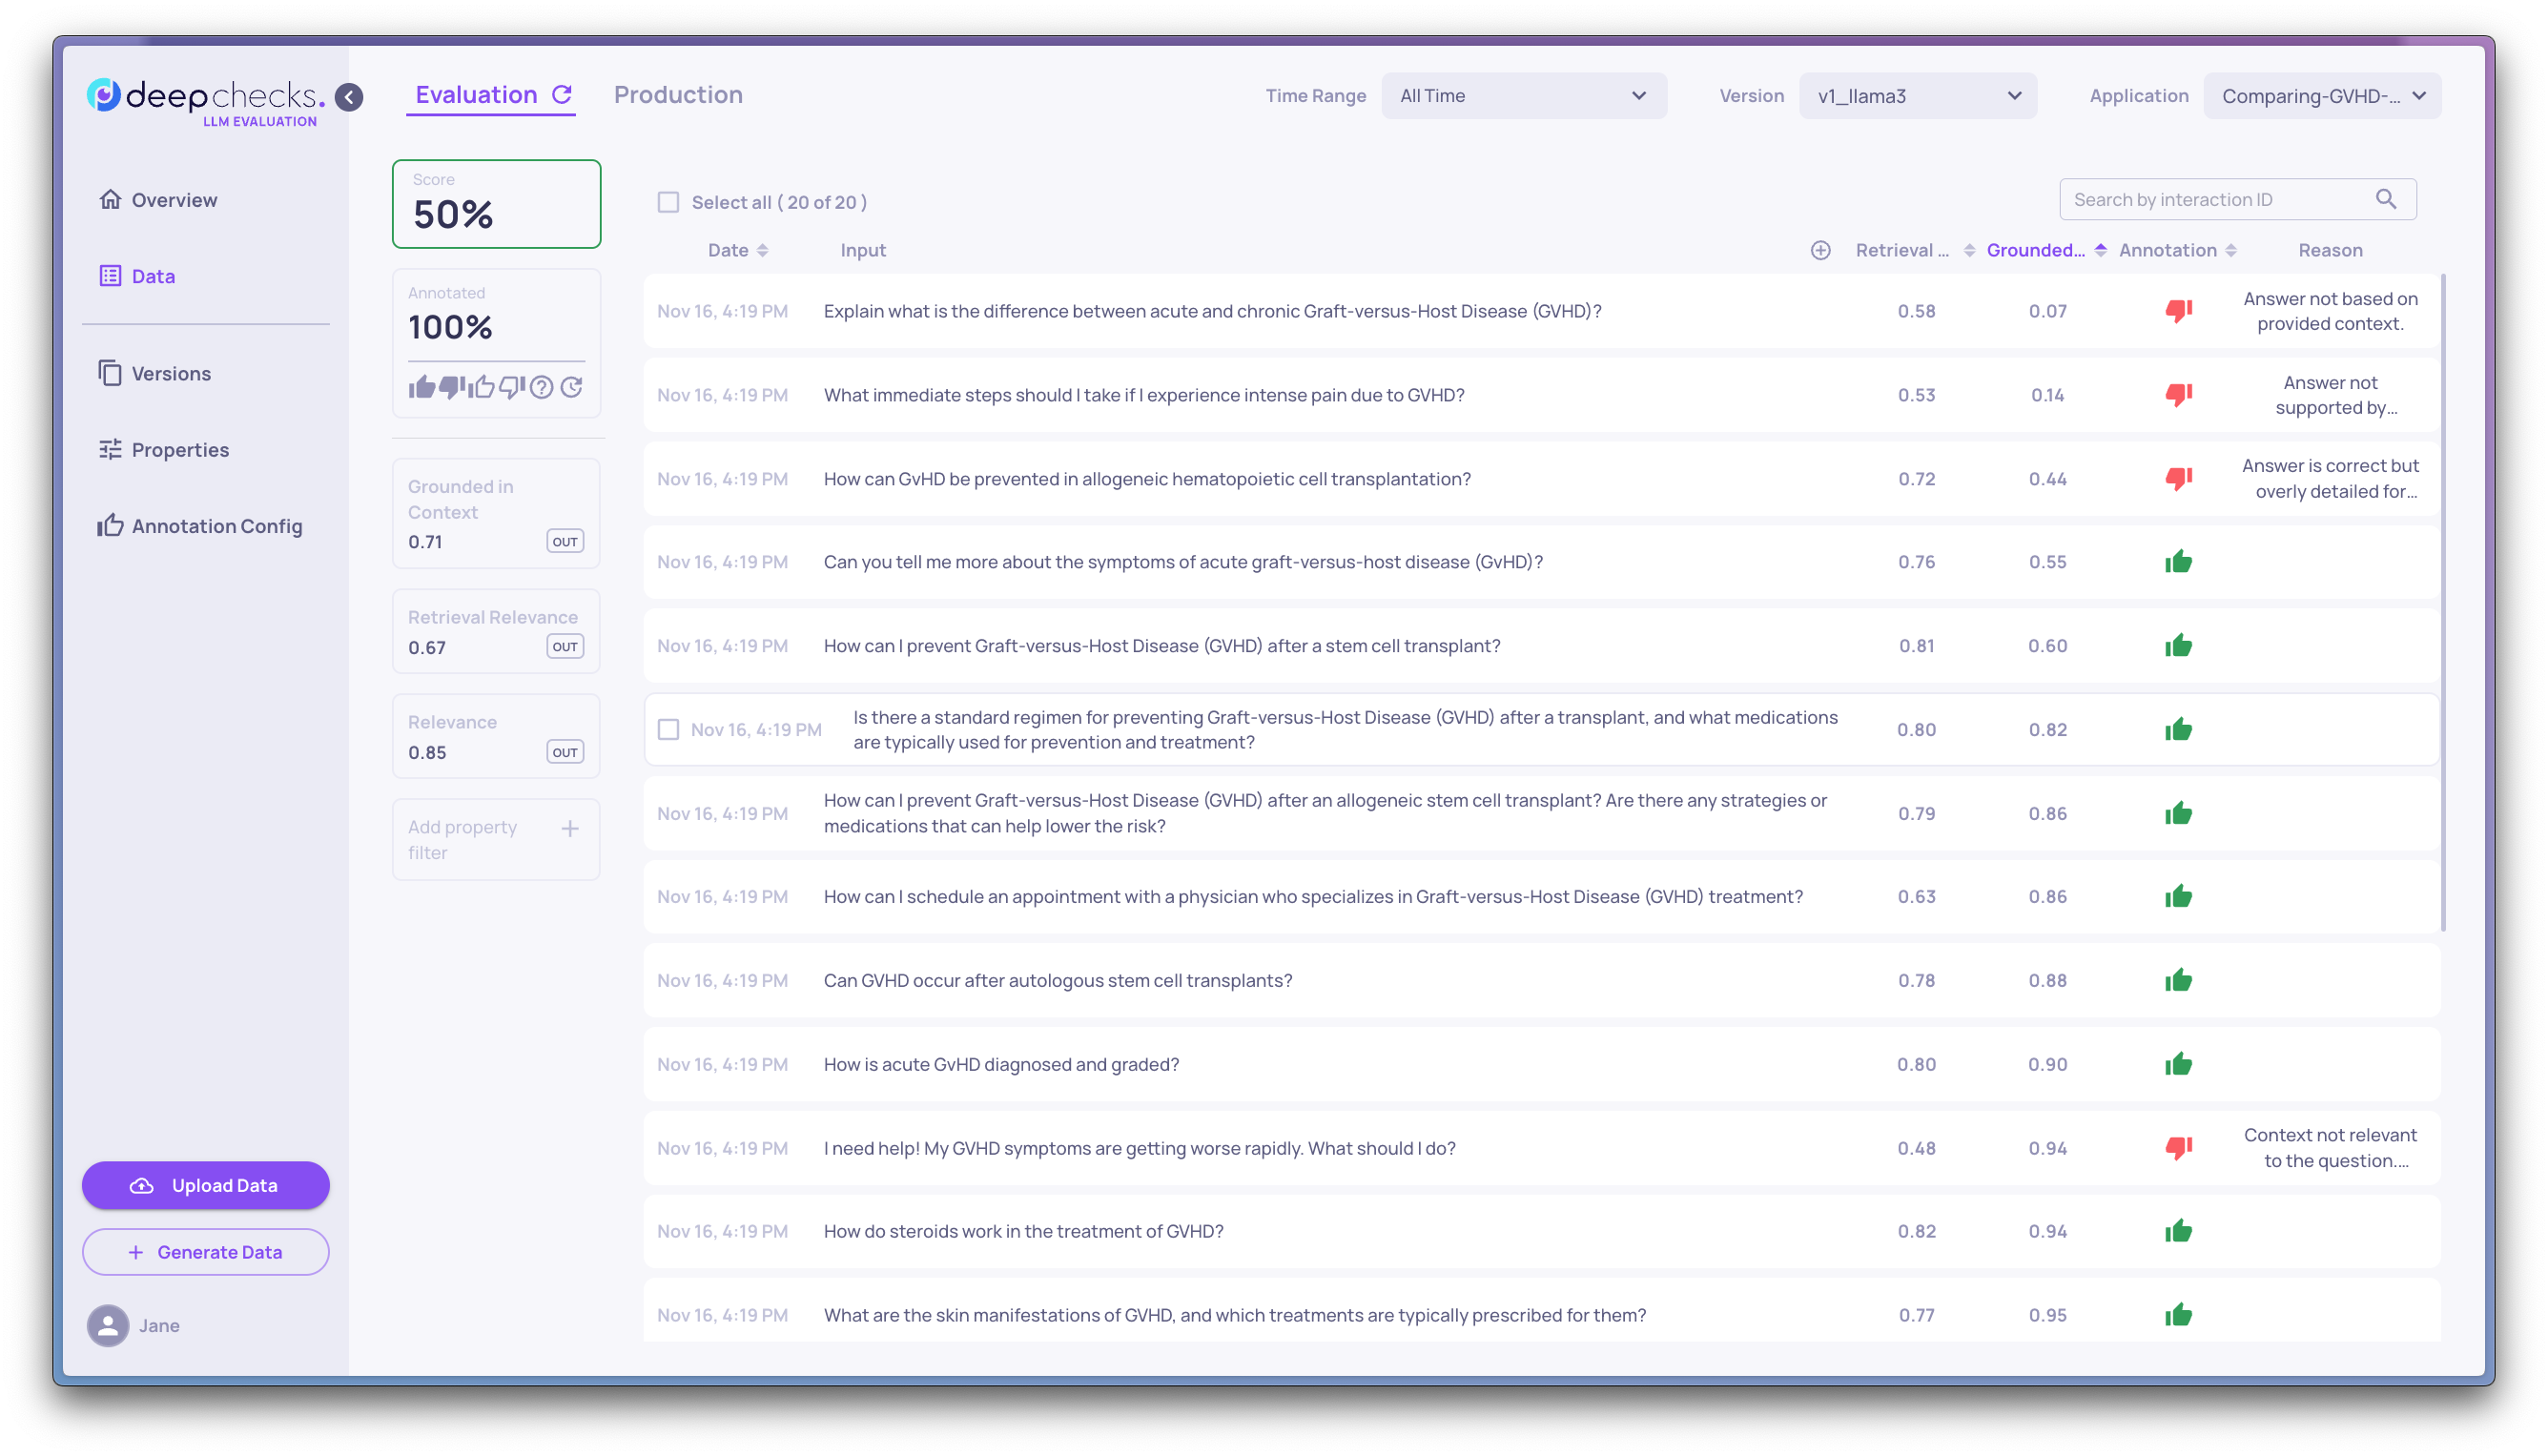

Click on one to see all relevant data fields and property scores.
Click on the Grounded in Context property itself (and other explainable properties) will highlight the chunks most contributing to the low score - meaning chunks that aren't grounded in the content of documents retrieved in the "Information Retrieval" field or mentioned in the "Full Prompt".
>ℹ️  Read more about each of the Deepchecks Properties in the "Properties" screen.

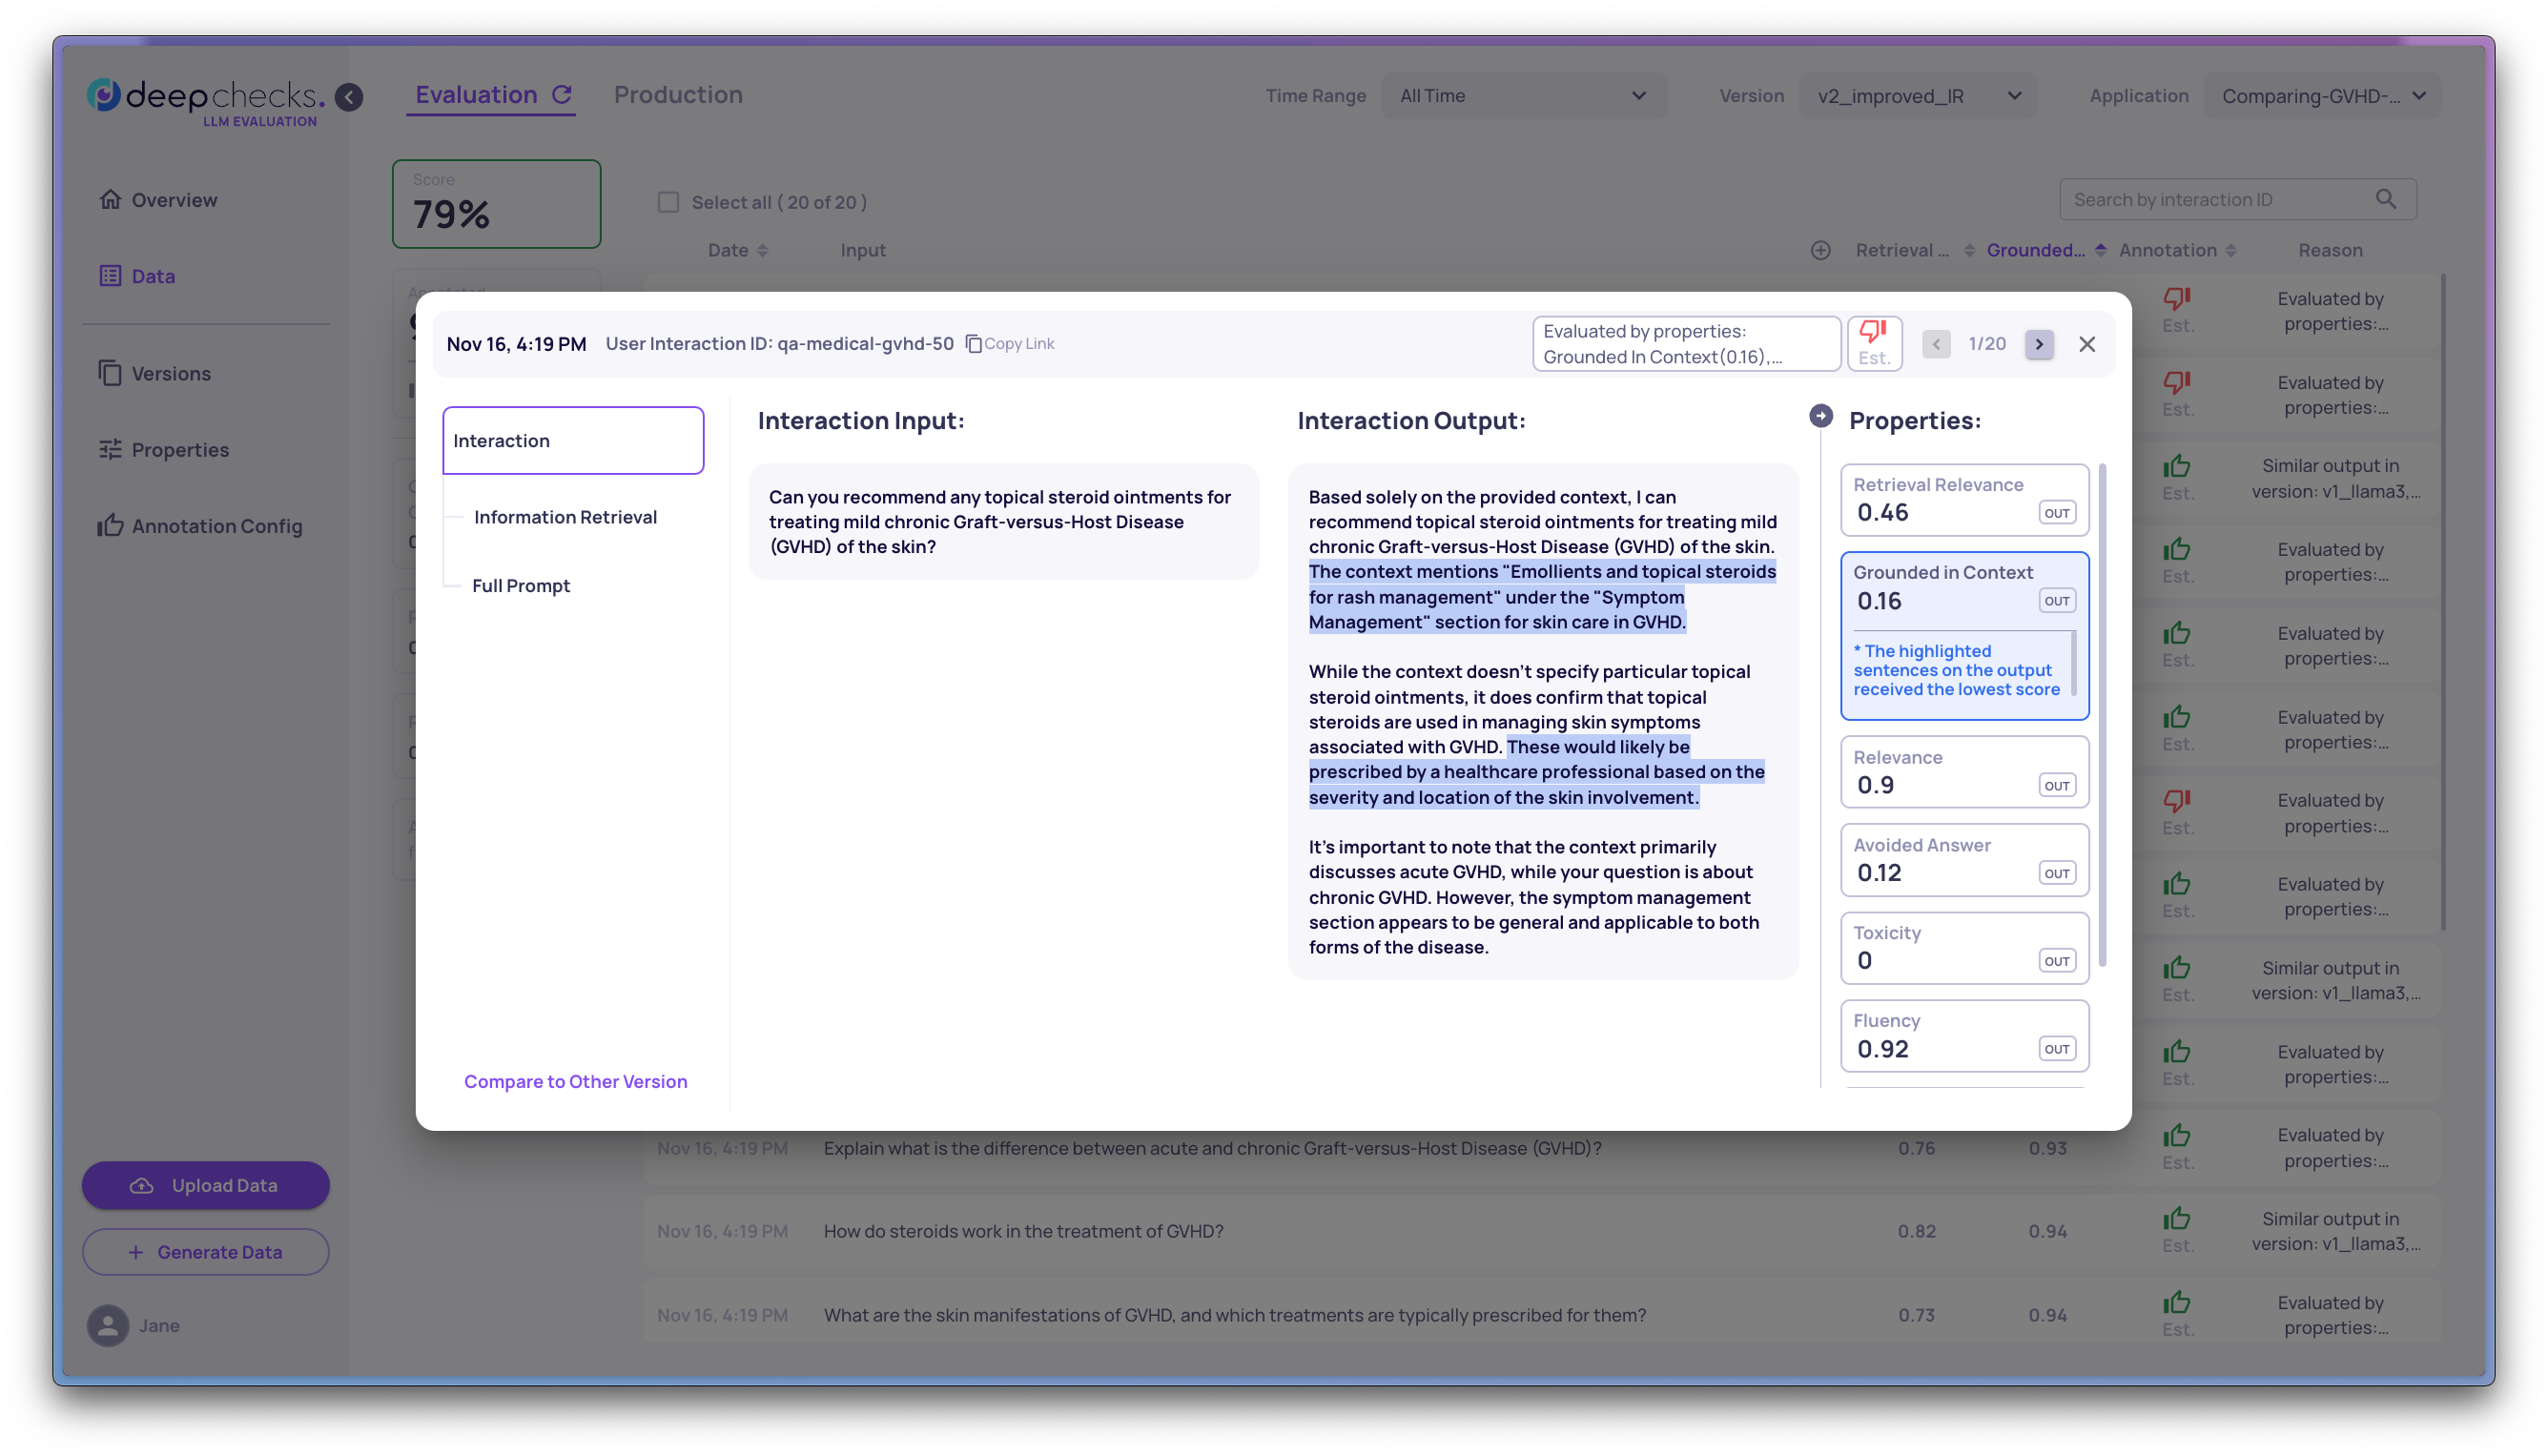

#### Version Comparison View

In the "Versions" Page, you can select two versions and click the "Compare Versions" button, to drill down into differences between the versions. E.g. Here we are checking which interactions' grounded in context scores were fixed after adding more data to v2, and verifying if there are any new problems.




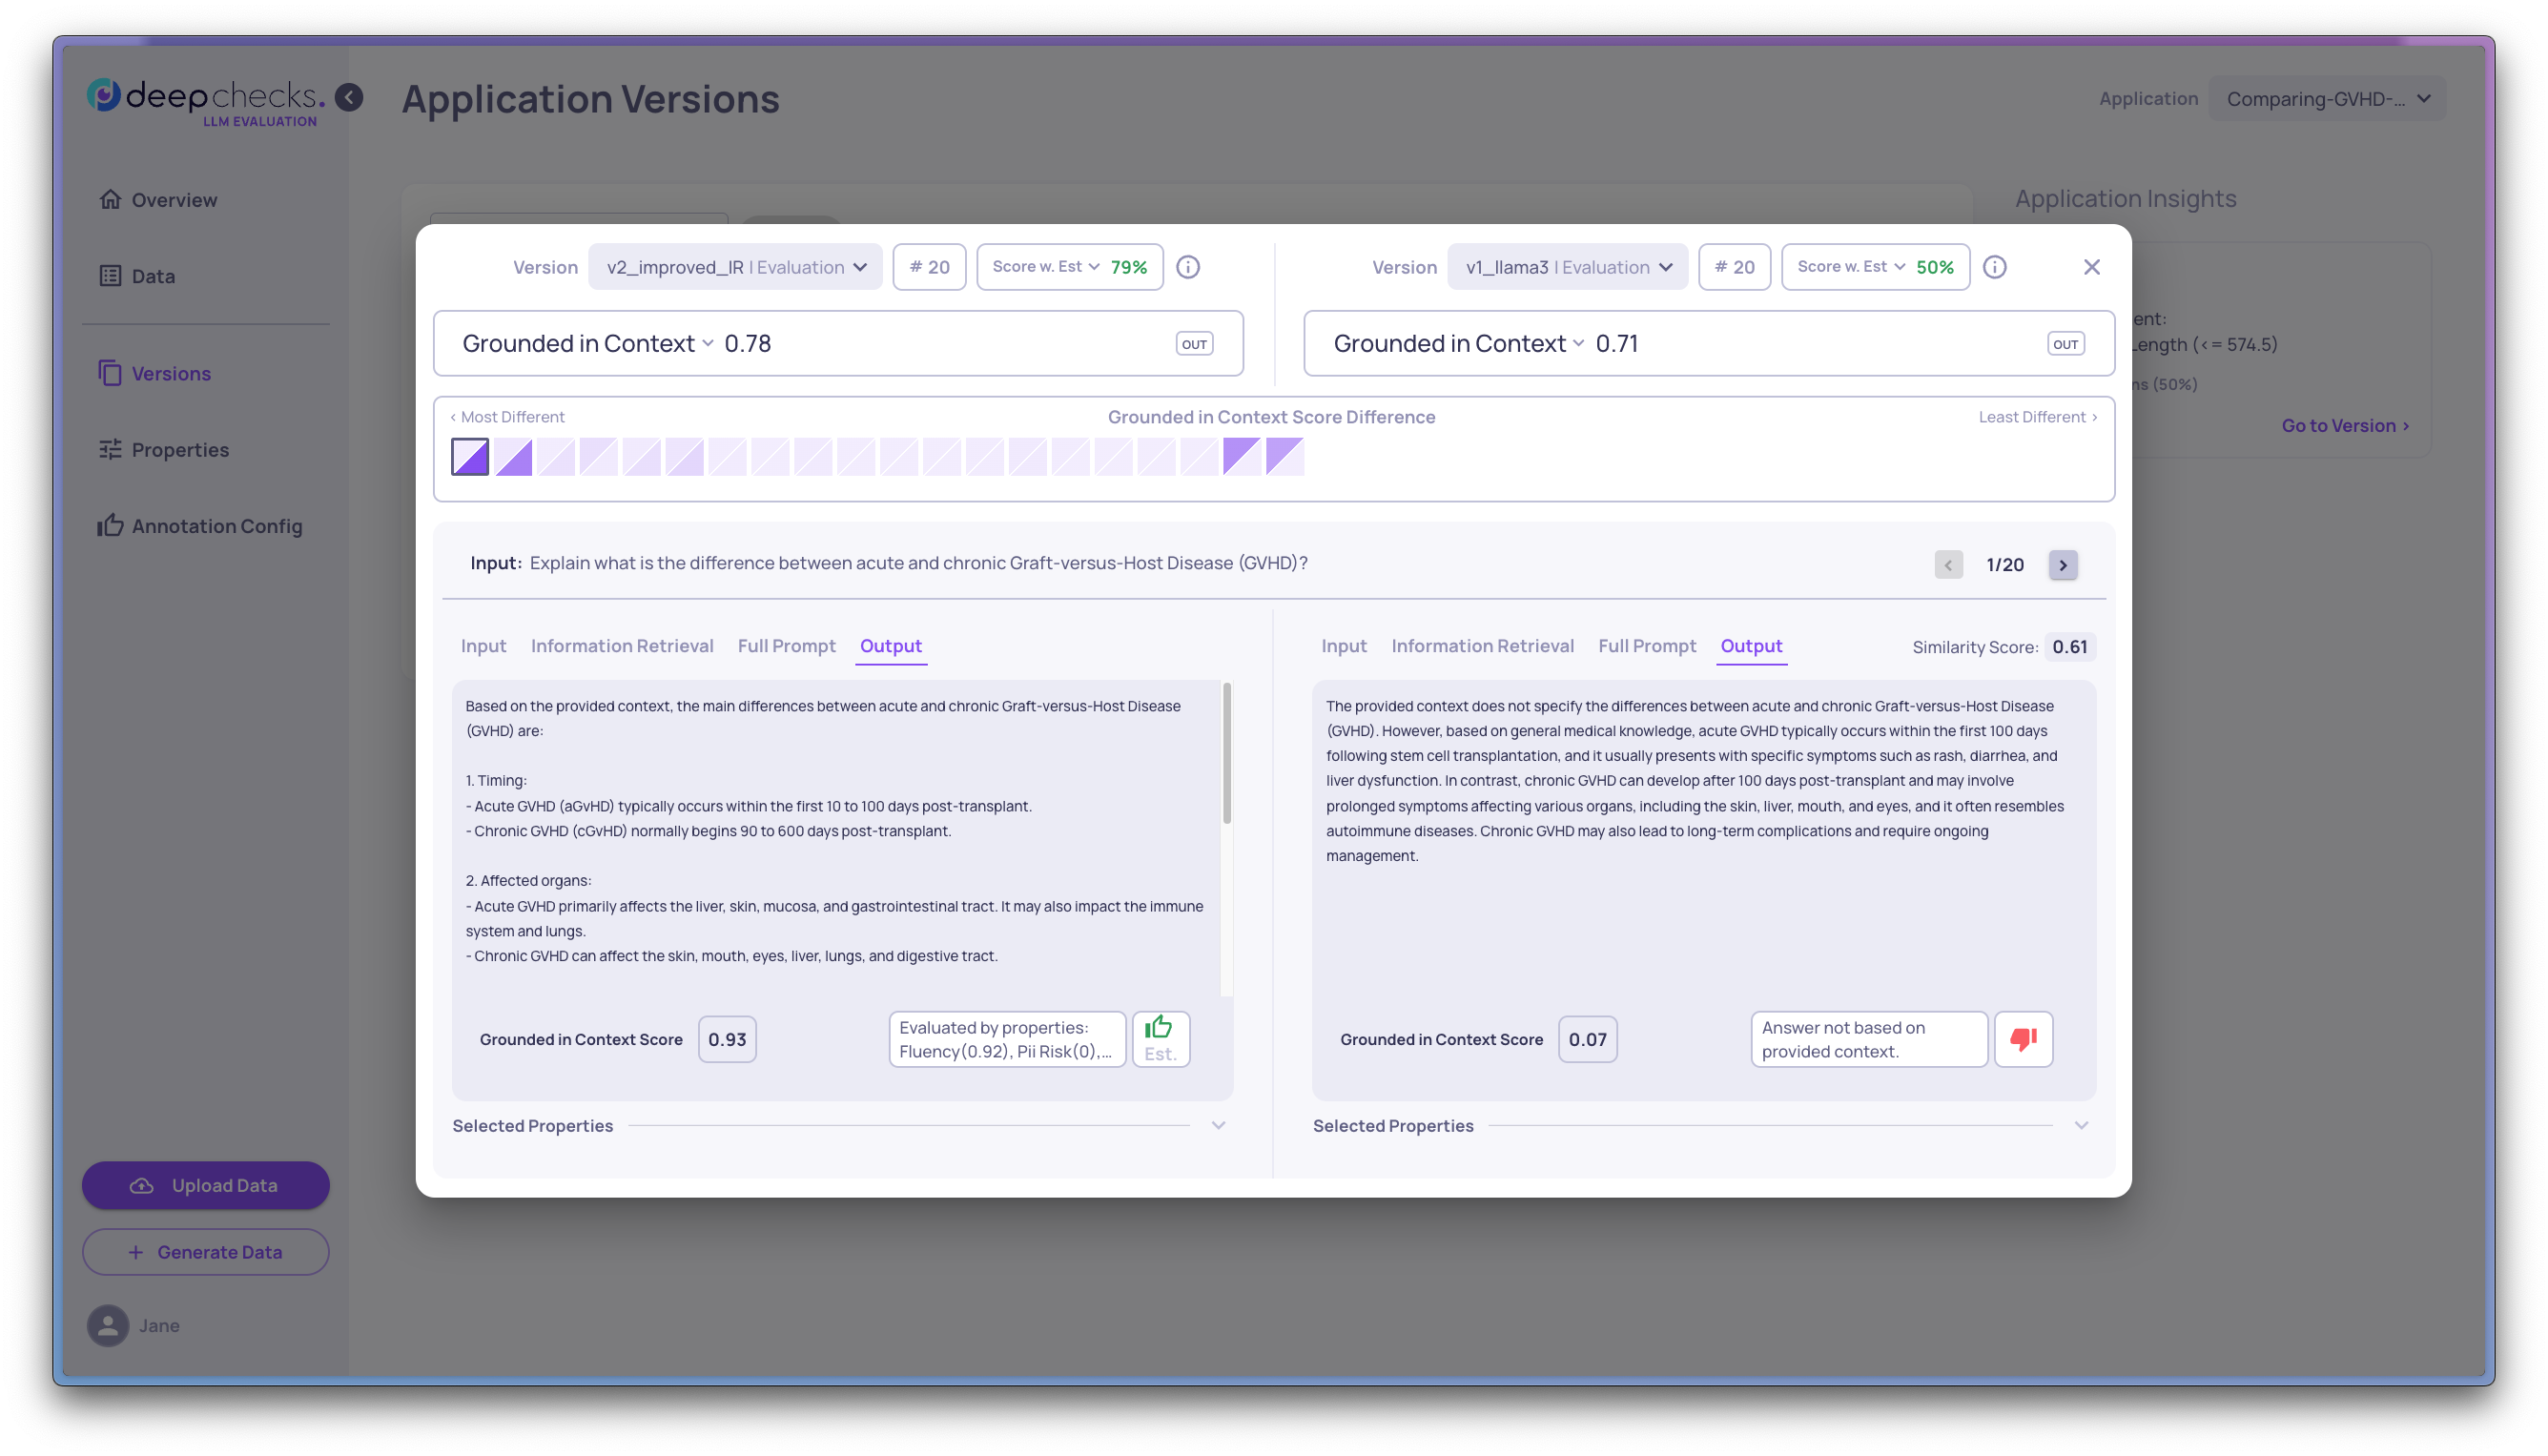

Using the versions page we can also get a high-level comparison between multiple versions. Here we can see the improvement in the Overall Score between the second improved version and our original version, alongside the average property values in those versions (e.g. a decrease in Avoided Answers, Grounded in Context, etc.)

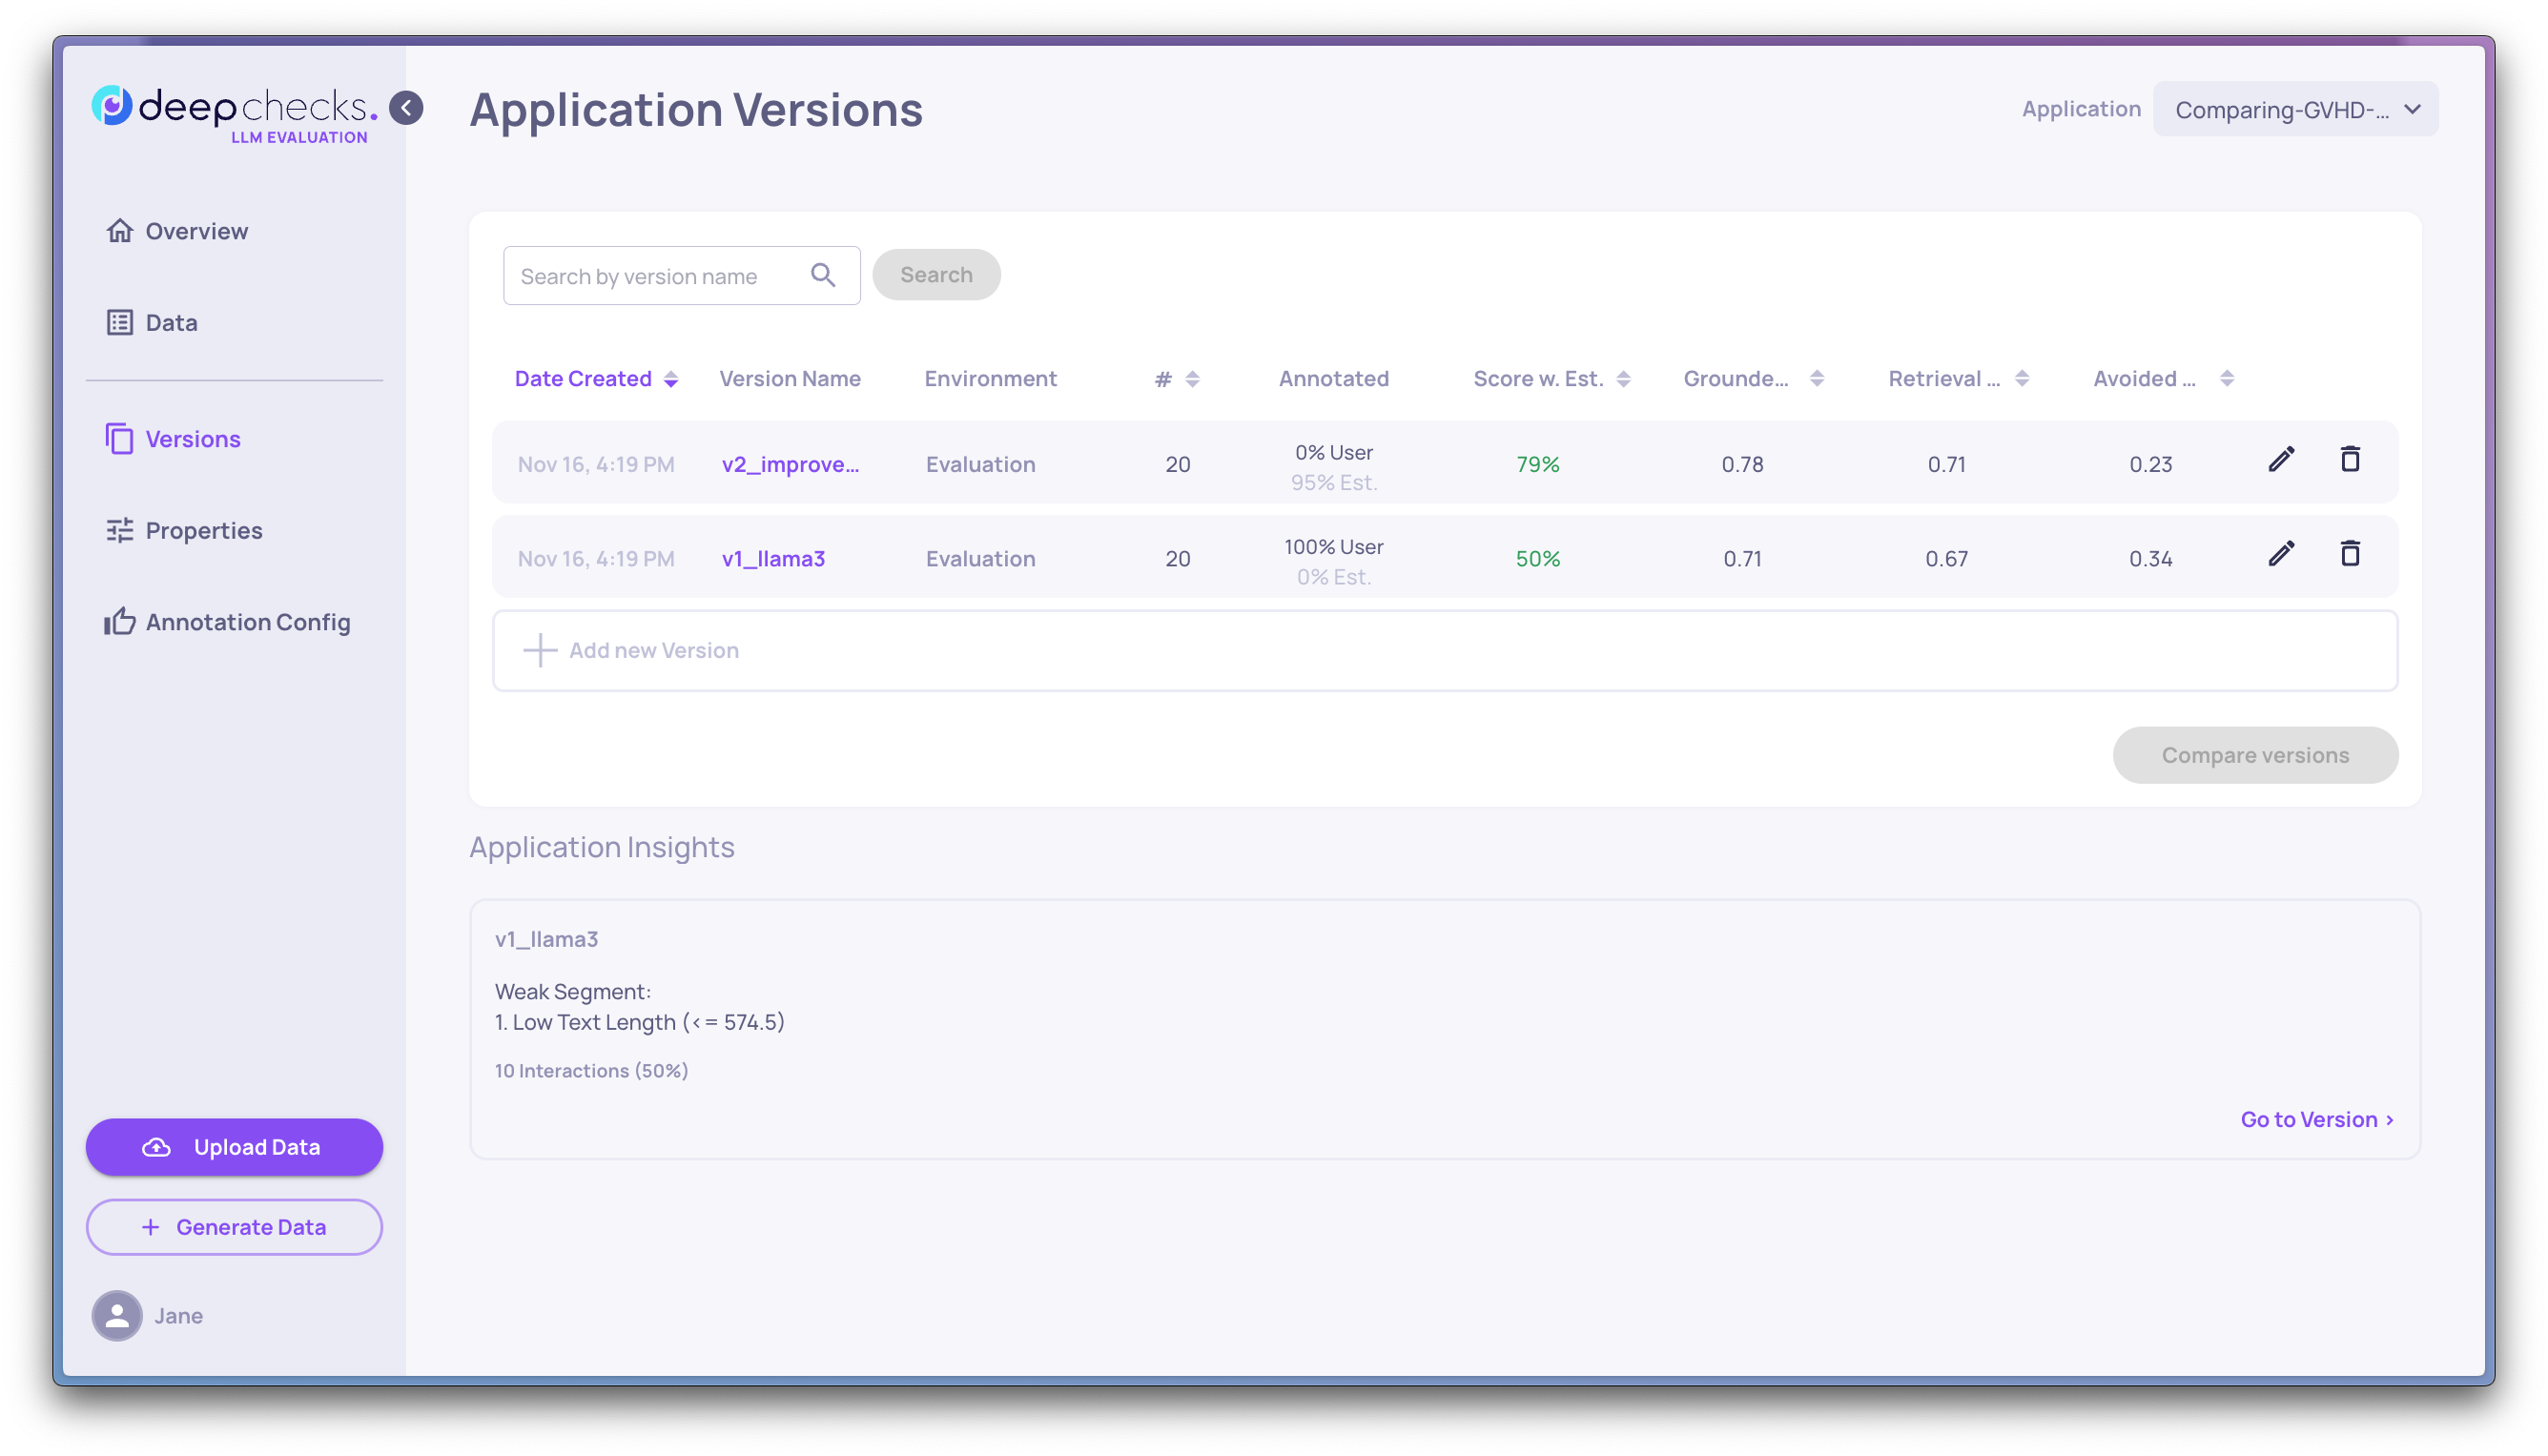

 After inspecting the second version's performance and properties, we decide it's ready to go, and it's now deployed to production and gets live user queries.

 ### Upload Production data from the deployed version for monitoring

  The production data is uploaded to the "Production" environment, for continuous monitoring and automated scoring, based on Deepchecks' properties and the configuration for automatic annotation.

In [ ]:
df_v2_prod = pd.read_csv("https://figshare.com/ndownloader/files/50598354")

dc_client.log_batch_interactions(
    app_name=APP_NAME,
    version_name="v2_improved_IR",
    env_type=EnvType.PROD,
    interactions=[
        LogInteractionType(
            input=row['input'],
            information_retrieval=row['information_retrieval'],
            output=row['output'],
            user_interaction_id=str(row['user_interaction_id']),
            full_prompt=row['full_prompt'],
            started_at=row['started_at'],
            custom_props={'Question Type': row['cp_Question Type']},
        ) for _, row in df_v2_prod.iterrows()
    ]
);

> 🗒️ Note: <br>
> Some properties take some time to calculate, so some of the data - such as properties and estimated annotations will be updated over time. You'll see a "✅ Completed" Processing Status in the Applications page, when processing is finished.
>
> **Make sure to "Refresh" the Deepchecks App to get the updated results**

Inspecting the performance of production data can help uncover tims where they get insufficient replies and the reasons for it (e.g. asking about a new topic, hallucinations in outputs, incomplete answers, etc.). Following these insights, a new fixed version can be created accordingly, automatically checked, updated to production, and vice versa.

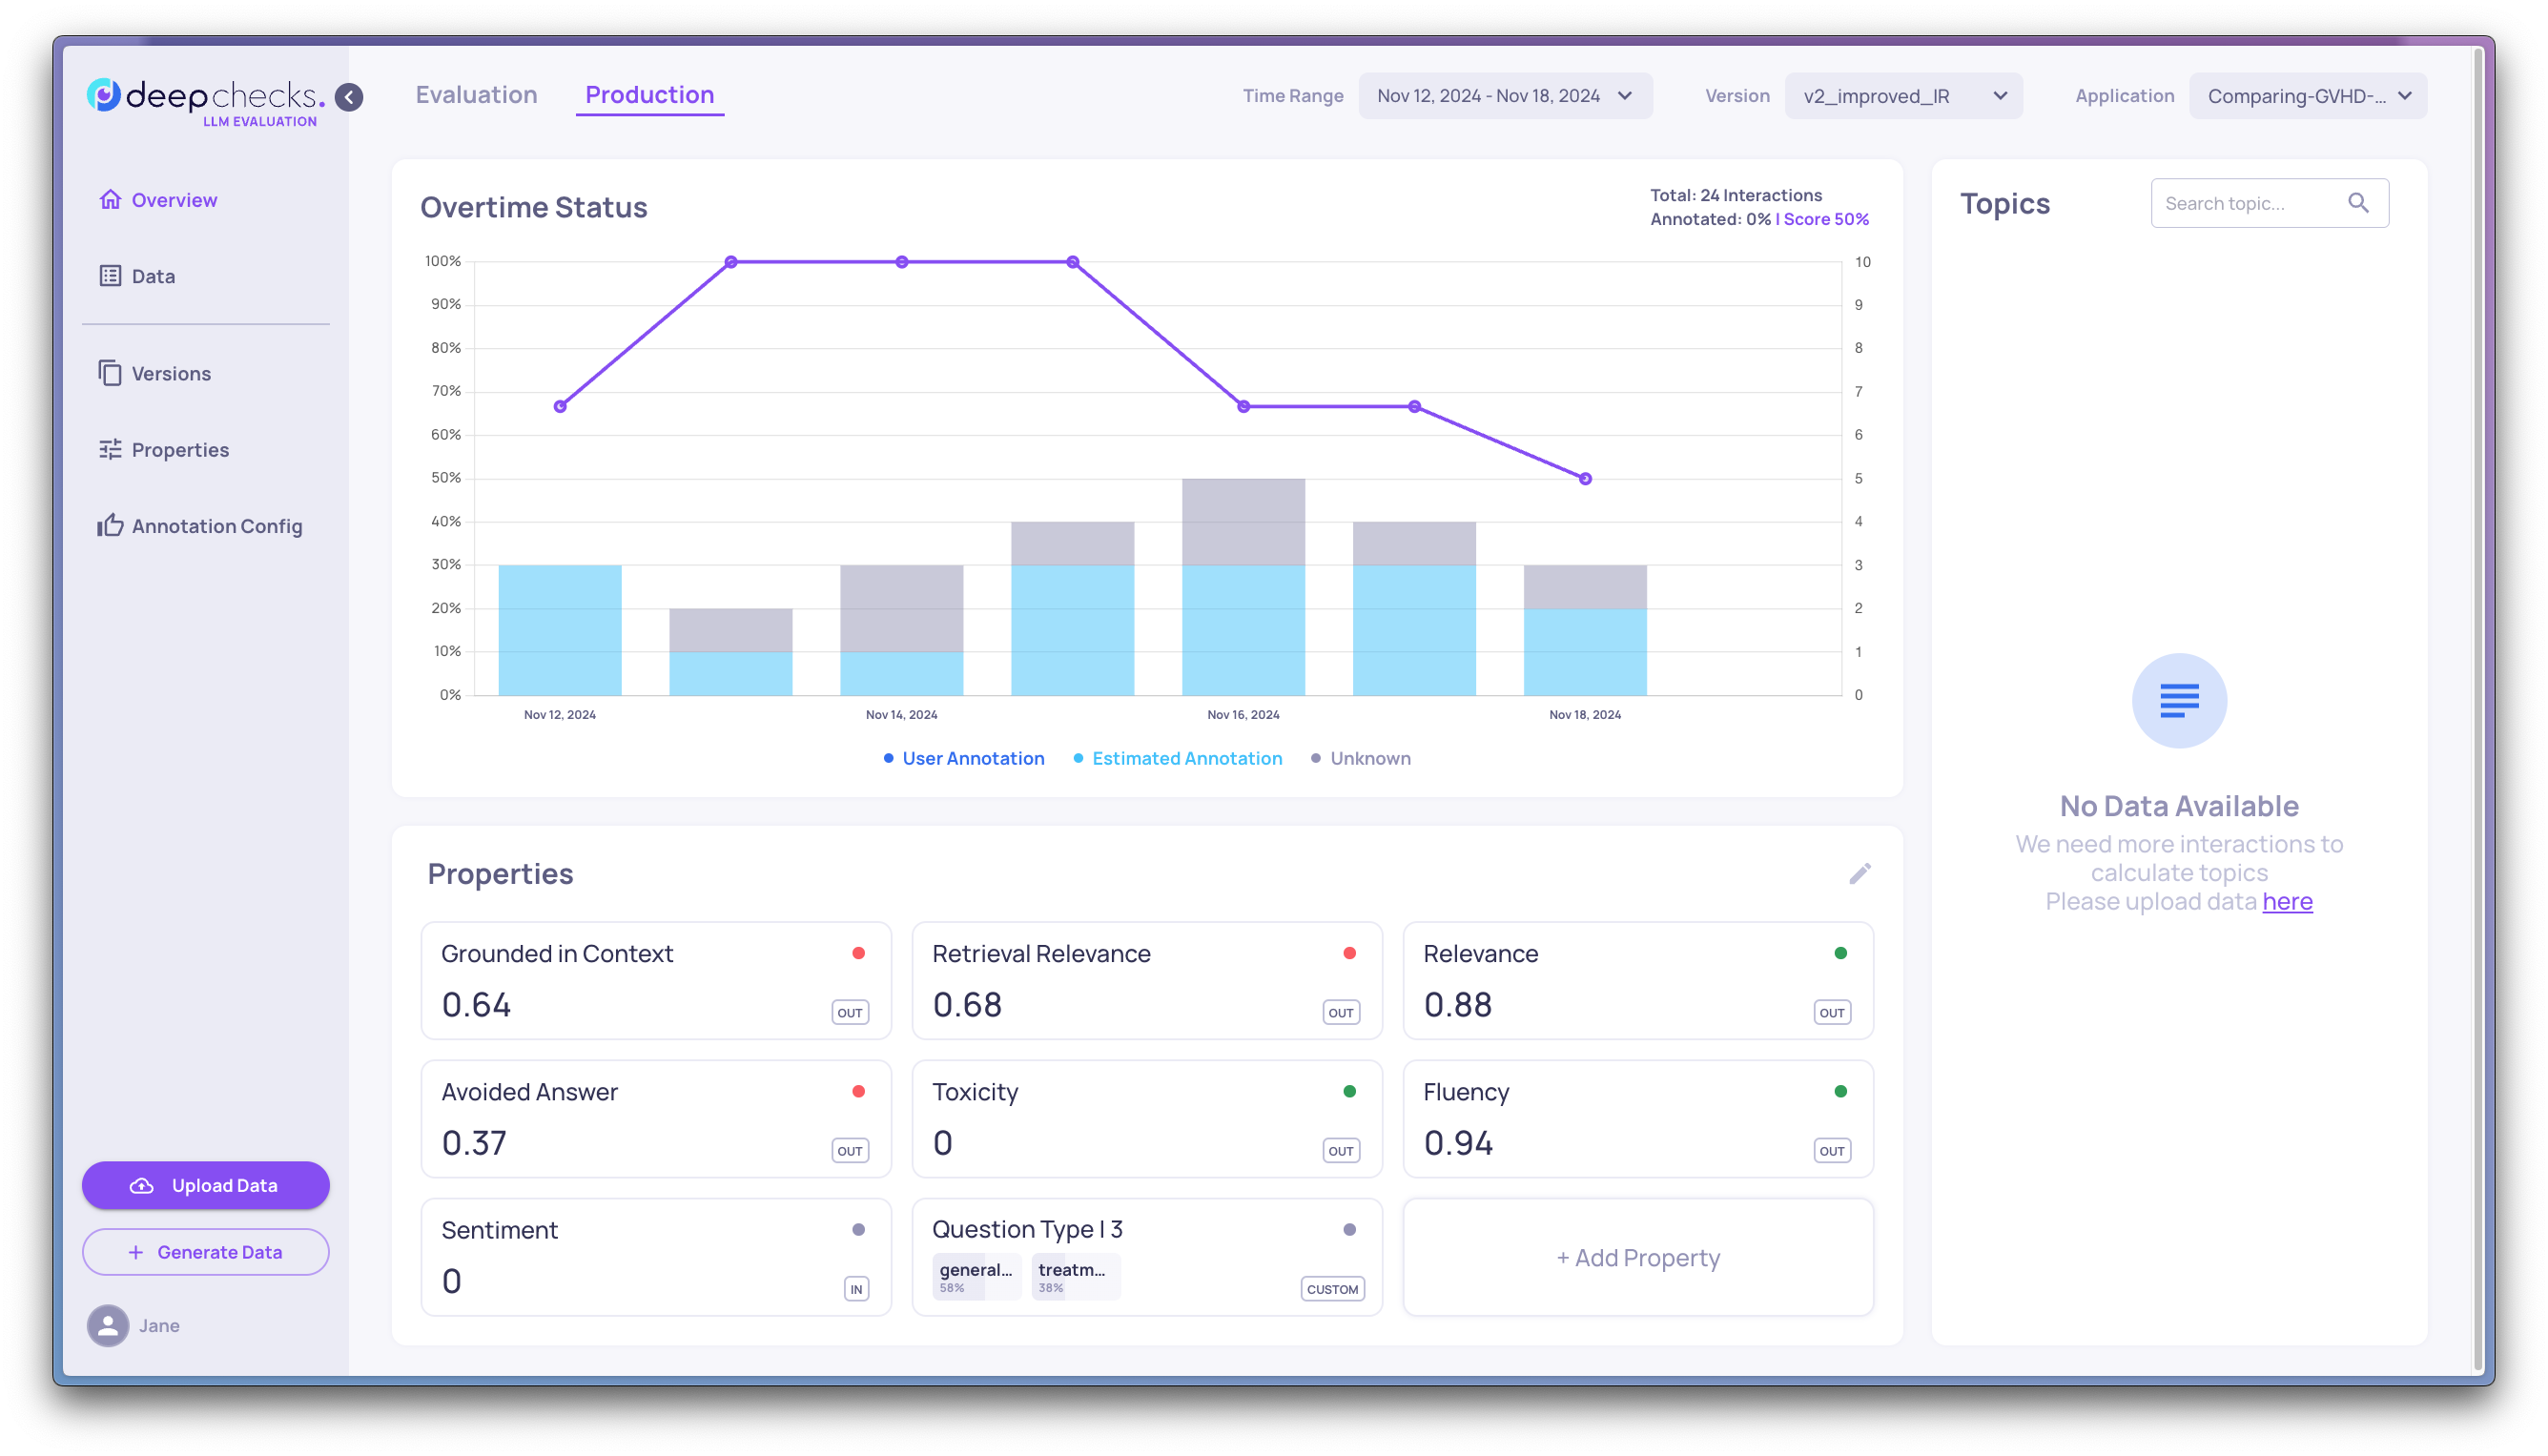